**Topic**: Fact checking, Neural Languange Inference (**NLI**)

# Intro

This project is centred on a particular and emerging NLP task, formally known as **fact checking** (or fake checking). As AI techniques become more and more powerful, reaching amazing results, such as image and text generation, it is more than ever necessary to build tools able to distinguish what is real from what is fake.

Here we focus on a small portion of the whole fact checking problem, which aims to determine whether a given statement (fact) conveys a trustworthy information or not. 

More precisely, given a set of evidences and a fact to verify, we would like our model to correctly predict whether the fact is true or fake.

In particular, we will see:

*   Dataset preparation (analysis and pre-processing)
*   Problem formulation: multi-input binary classification
*   Defining an evaluation method
*   Simple sentence embedding
*   Neural building blocks
*   Neural architecture extension

# The FEVER dataset

First of all, we need to choose a dataset. In this assignment we will rely on the [FEVER dataset](https://fever.ai).

The dataset is about facts taken from Wikipedia documents that have to be verified. In particular, facts could face manual modifications in order to define fake information or to give different formulations of the same concept.

The dataset consists of 185,445 claims manually verified against the introductory sections of Wikipedia pages and classified as ```Supported```, ```Refuted``` or ```NotEnoughInfo```. For the first two classes, systems and annotators need to also return the combination of sentences forming the necessary evidence supporting or refuting the claim.

## 2.1 Dataset structure

Relevant data is divided into two file types. Information concerning the fact to verify, its verdict and associated supporting/opposing statements are stored in **.jsonl** format. In particular, each JSON element is a python dictionary with the following relevant fields:

*    **ID**: ID associated to the fact to verify.

*    **Verifiable**: whether the fact has been verified or not: ```VERIFIABLE``` or ```NOT VERIFIABLE```.
    
*    **Label**: the final verdict on the fact to verify: ```SUPPORTS```, ```REFUTES``` or ```NOT ENOUGH INFO```.
    
*    **Claim**: the fact to verify.
    
*    **Evidence**: a nested list of document IDs along with the sentence ID that is associated to the fact to verify. In particular, each list element is a tuple of four elements: the first two are internal annotator IDs that can be safely ignored; the third term is the document ID (called URL) and the last one is the sentence number (ID) in the pointed document to consider.

**Some Examples**

---

**Verifiable**

```
{"id": 202314, "verifiable": "VERIFIABLE", "label": "REFUTES", "claim": "The New Jersey Turnpike has zero shoulders.", "evidence": [[[238335, 240393, "New_Jersey_Turnpike", 15]]]}
```

---

**Not Verifiable**

```
{"id": 113501, "verifiable": "NOT VERIFIABLE", "label": "NOT ENOUGH INFO", "claim": "Grease had bad reviews.", "evidence": [[[133128, null, null, null]]]}
```

---

## 2.2 Some simplifications and pre-processing

We are only interested in verifiable facts. Thus, we can filter out all non-verifiable claims.

Additionally, the current dataset format does not contain all necessary information for our classification purposes. In particular, we need to download Wikipedia documents and replace reported evidence IDs with the corresponding text.

Don't worry about that! We are providing you the already pre-processed dataset so that you can concentrate on the classification pipeline (pre-processing, model definition, evaluation and training).

You can download the zip file containing all set splits (train, validation and test) of the FEVER dataset by clicking on this [link](https://drive.google.com/file/d/1wArZhF9_SHW17WKNGeLmX-QTYw9Zscl1/view?usp=sharing). Alternatively, run the below code cell to automatically download it on this notebook.

**Note**: each dataset split is in .csv format. Feel free to inspect the whole dataset!

In [4]:
import os
import re
import nltk
import string
import random
import gensim
import zipfile
import sklearn
import requests
import numpy as np
import pandas as pd

In [5]:

import matplotlib.pyplot as plt
# import seaborn as sns

from tqdm import tqdm
from itertools import chain
from functools import reduce
from functools import partial
import matplotlib.pyplot as plt
from collections import namedtuple
import gensim.downloader as gloader
from collections import OrderedDict, Counter
from utils_ import utility

In [6]:
def save_response_content(response, destination):
    CHUNK_SIZE = 32768

    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)

def download_data(data_path):
    toy_data_path = os.path.join(data_path, 'fever_data.zip')
    toy_data_url_id = "1wArZhF9_SHW17WKNGeLmX-QTYw9Zscl1"
    toy_url = "https://docs.google.com/uc?export=download"

    if not os.path.exists(data_path):
        os.makedirs(data_path)

    if not os.path.exists(toy_data_path):
        print("Downloading FEVER data splits...")
        with requests.Session() as current_session:
            response = current_session.get(toy_url,
                                   params={'id': toy_data_url_id},
                                   stream=True)
        save_response_content(response, toy_data_path)
        print("Download completed!")

        print("Extracting dataset...")
        with zipfile.ZipFile(toy_data_path) as loaded_zip:
            loaded_zip.extractall(data_path)
        print("Extraction completed!")

download_data('dataset')

Download completed!
Extracting dataset...
Extraction completed!


Reading Data from the extracted .csv files


In [7]:
folder = os.path.join(os.getcwd(), "dataset")
# files=os.listdir(folder)

df_train = pd.read_csv(folder + '/'+ 'train_pairs.csv', index_col = [0])
df_test = pd.read_csv(folder + '/' +  'test_pairs.csv', index_col = [0])
df_val = pd.read_csv(folder + '/' + 'val_pairs.csv', index_col = [0])


In [8]:
df_train.shape

(121740, 4)

In [9]:
df_train.head()

,Claim,Evidence,ID,Label
0,Chris Hemsworth appeared in A Perfect Getaway.,2\tHemsworth has also appeared in the science ...,3,SUPPORTS
1,Roald Dahl is a writer.,0\tRoald Dahl -LRB- -LSB- langpronˈroʊ.əld _ ˈ...,7,SUPPORTS
2,Roald Dahl is a governor.,0\tRoald Dahl -LRB- -LSB- langpronˈroʊ.əld _ ˈ...,8,REFUTES
3,Ireland has relatively low-lying mountains.,10\tThe island 's geography comprises relative...,9,SUPPORTS
4,Ireland does not have relatively low-lying mou...,10\tThe island 's geography comprises relative...,10,REFUTES


#Exploration

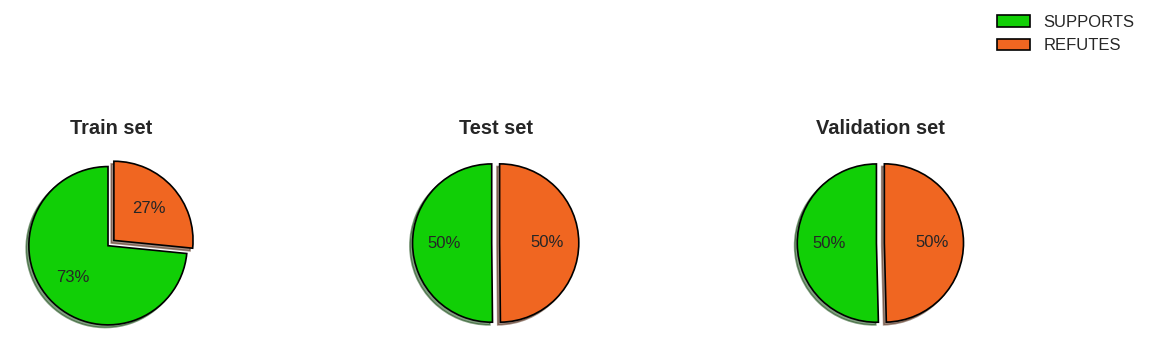

In [10]:
plt.style.use('seaborn')
TRNLBL = df_train['Label'].value_counts().to_frame().T
TSTLBL = df_test['Label'].value_counts().to_frame().T
VALLBL = df_val['Label'].value_counts().to_frame().T
total = pd.concat([TRNLBL, TSTLBL, VALLBL])
fig, ax = plt.subplots(nrows=1, ncols=3, dpi = 120)

labels = 'SUPPORTS', 'REFUTES'
colors = ['#11CF06', '#F06621']
explode = (0.05, 0.05)

plt.title('Pie chart for Labels in Train Test and Validation set')
plt.tight_layout()
ax[0].pie(total.iloc[0], startangle=90, colors=colors, wedgeprops={'edgecolor': 'black', 'linewidth':1}, explode=explode, autopct='%1.f%%', shadow=True)
ax[0].set_title('Train set', fontweight='bold')
ax[1].pie(total.iloc[1],  startangle=90, colors=colors, wedgeprops={'edgecolor': 'black', 'linewidth':1}, autopct='%1.f%%', explode=explode, shadow=True)
ax[1].set_title('Test set', fontweight='bold')
ax[2].pie(total.iloc[2],  startangle=90, colors=colors, wedgeprops={'edgecolor': 'black', 'linewidth':1}, autopct='%1.f%%', explode=explode, shadow=True)
ax[2].set_title('Validation set', fontweight='bold')
fig.set_figheight(4)
fig.set_figwidth(10)
fig.legend(labels=labels, fontsize='medium')

fig.savefig('Label distribution in dataframes')

plt.show()

In [11]:
TAB_CHAR = "\t"
PERIOD_CHAR = "."
LEFT_PARENS = "-LRB-"
RIGHT_PARENS = "-RRB-"
SQUARE_BRACKETS = r"-LSB-.*-RSB-"

In [12]:
s = 'strj   jgk;dg   sug'
s.find(TAB_CHAR)
s.count(TAB_CHAR)
print(s)
s = s[:s.find(TAB_CHAR)]+s[s.find(TAB_CHAR)+len(TAB_CHAR):]
print(s)

strj   jgk;dg   sug
strj   jgk;dg   sustrj   jgk;dg   sug


In [13]:
# df

In [14]:
df_train

,Claim,Evidence,ID,Label
0,Chris Hemsworth appeared in A Perfect Getaway.,2\tHemsworth has also appeared in the science ...,3,SUPPORTS
1,Roald Dahl is a writer.,0\tRoald Dahl -LRB- -LSB- langpronˈroʊ.əld _ ˈ...,7,SUPPORTS
2,Roald Dahl is a governor.,0\tRoald Dahl -LRB- -LSB- langpronˈroʊ.əld _ ˈ...,8,REFUTES
3,Ireland has relatively low-lying mountains.,10\tThe island 's geography comprises relative...,9,SUPPORTS
4,Ireland does not have relatively low-lying mou...,10\tThe island 's geography comprises relative...,10,REFUTES
...,...,...,...,...
121735,April was the month Anderson Silva was born.,0\tAnderson da Silva -LRB- -LSB- ˈɐ̃deʁsõ ˈsiw...,229440,SUPPORTS
121736,Anderson Silva is an American Brazilian mixed ...,0\tAnderson da Silva -LRB- -LSB- ˈɐ̃deʁsõ ˈsiw...,229443,REFUTES
121737,Anderson Silva is incapable of being a Brazili...,0\tAnderson da Silva -LRB- -LSB- ˈɐ̃deʁsõ ˈsiw...,229444,REFUTES
121738,Anderson Silva was born on the month of April ...,0\tAnderson da Silva -LRB- -LSB- ˈɐ̃deʁsõ ˈsiw...,229445,SUPPORTS


#Preprocess

# Classification dataset

At this point, you should have a reay-to-go dataset! Note that the dataset format changed as well! In particular, we split the evidence set associated to each claim, in order to build `(claim, evidence)` pairs. The classification label is propagated as well.

We'll motivate this decision in the next section!

Just for clarity, here's an example of the pre-processed dataset:

---

**Claim**: "Wentworth Miller is yet to make his screenwriting debut."

**Evidence**: "2	He made his screenwriting debut with the 2013 thriller film Stoker .	Stoker	Stoker (film)"

**Label**: Refutes

---

[**Note**]: The dataset requires some text cleaning as you may have noticed!


In [15]:
import re
from functools import reduce
import nltk
from nltk.corpus import stopwords

# Config

REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
REPLACE_BY_ = re.compile('_')
GOOD_SYMBOLS_RE = re.compile("^[a-zA-Z0-9_-]*$")

try:
    STOPWORDS = set(stopwords.words('english'))
except LookupError:
    nltk.download('stopwords')
    STOPWORDS = set(stopwords.words('english'))

def lower(text: str) -> str:
    """
    Transforms given text to lower case.
    Example:
    Input: 'I really like New York city'
    Output: 'i really like new your city'
    """

    return text.lower()

def replace_special_characters(text: str) -> str:
    """
    Replaces special characters, such as paranthesis,
    with spacing character
    """

    return REPLACE_BY_SPACE_RE.sub(' ', text)


def replace_by_underscore(text: str) -> str:
    """
    Replaces special characters, such as paranthesis,
    with spacing character
    """

    return REPLACE_BY_.sub(' ', text)

def replace_br(text: str) -> str:
    """
    Replaces br characters
    """

    return text.replace('br', '')

def filter_out_uncommon_symbols(text: str) -> str:
    """
    Removes any special character that is not in the
    good symbols list (check regular expression)
    """

    return GOOD_SYMBOLS_RE.sub('', text)

def remove_stopwords(text: str) -> str:
    return ' '.join([x for x in text.split() if x and x not in STOPWORDS])


def strip_text(text: str) -> str:
    """
    Removes any left or right spacing (including carriage return) from text.
    Example:
    Input: '  This assignment is cool\n'
    Output: 'This assignment is cool'
    """

    return text.strip()

PREPROCESSING_PIPELINE = [
                          lower,
                          replace_special_characters,
                          replace_br,
                          filter_out_uncommon_symbols,
                          replace_by_underscore,
                          remove_stopwords,
                          strip_text
                          ]

# Anchor method

def text_prepare(text: str,filter_methods = None) -> str:
    """
    Applies a list of pre-processing functions in sequence (reduce).
    Note that the order is important here!
    """

    filter_methods = filter_methods if filter_methods is not None else PREPROCESSING_PIPELINE

    return reduce(lambda txt, f: f(txt), filter_methods, text)


L=['Claim','Evidence']

for i in L:
  df_train[i] = df_train[i].apply(lambda txt: text_prepare(txt))
  df_test[i] = df_test[i].apply(lambda txt: text_prepare(txt))
  df_val[i] = df_val[i].apply(lambda txt: text_prepare(txt))

df_train

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,Claim,Evidence,ID,Label
0,chris hemsworth appeared perfect getaway.,2 hemsworth also appeared science fiction acti...,3,SUPPORTS
1,roald dahl writer.,0 roald dahl -lrb- -lsb- langpronˈroʊ.əld ˈdɑː...,7,SUPPORTS
2,roald dahl governor.,0 roald dahl -lrb- -lsb- langpronˈroʊ.əld ˈdɑː...,8,REFUTES
3,ireland relatively low-lying mountains.,10 island 's geography comprises relatively lo...,9,SUPPORTS
4,ireland relatively low-lying mountains.,10 island 's geography comprises relatively lo...,10,REFUTES
...,...,...,...,...
121735,april month anderson silva born.,0 anderson da silva -lrb- -lsb- ˈɐ̃deʁsõ ˈsiwv...,229440,SUPPORTS
121736,anderson silva american azilian mixed martial ...,0 anderson da silva -lrb- -lsb- ˈɐ̃deʁsõ ˈsiwv...,229443,REFUTES
121737,anderson silva incapable azilian mixed martial...,0 anderson da silva -lrb- -lsb- ˈɐ̃deʁsõ ˈsiwv...,229444,REFUTES
121738,anderson silva born month april 14th 1975.,0 anderson da silva -lrb- -lsb- ˈɐ̃deʁsõ ˈsiwv...,229445,SUPPORTS


In [16]:
df_train.Evidence[0]

'2 hemsworth also appeared science fiction action film star trek -lrb- 2009 -rrb- thriller adventure perfect getaway -lrb- 2009 -rrb- horror comedy cabin woods -lrb- 2012 -rrb- dark-fantasy action film snow white huntsman -lrb- 2012 -rrb- war film red dawn -lrb- 2012 -rrb- biographical sports drama film rush -lrb- 2013 -rrb- . star trek star trek film perfect getaway perfect getaway cabin woods cabin woods snow white huntsman snow white huntsman red dawn red dawn 2012 film rush rush 2013 film'

In [17]:
df_train['Label'].loc[(df_train['Label'] == 'SUPPORTS')] = 1
df_train['Label'].loc[(df_train['Label'] == 'REFUTES')] = 0 

df_val['Label'].loc[(df_val['Label'] == 'SUPPORTS')] = 1
df_val['Label'].loc[(df_val['Label'] == 'REFUTES')] = 0 


df_test['Label'].loc[(df_test['Label'] == 'SUPPORTS')] = 1
df_test['Label'].loc[(df_test['Label'] == 'REFUTES')] = 0 

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [18]:
df_train

,Claim,Evidence,ID,Label
0,chris hemsworth appeared perfect getaway.,2 hemsworth also appeared science fiction acti...,3,1
1,roald dahl writer.,0 roald dahl -lrb- -lsb- langpronˈroʊ.əld ˈdɑː...,7,1
2,roald dahl governor.,0 roald dahl -lrb- -lsb- langpronˈroʊ.əld ˈdɑː...,8,0
3,ireland relatively low-lying mountains.,10 island 's geography comprises relatively lo...,9,1
4,ireland relatively low-lying mountains.,10 island 's geography comprises relatively lo...,10,0
...,...,...,...,...
121735,april month anderson silva born.,0 anderson da silva -lrb- -lsb- ˈɐ̃deʁsõ ˈsiwv...,229440,1
121736,anderson silva american azilian mixed martial ...,0 anderson da silva -lrb- -lsb- ˈɐ̃deʁsõ ˈsiwv...,229443,0
121737,anderson silva incapable azilian mixed martial...,0 anderson da silva -lrb- -lsb- ˈɐ̃deʁsõ ˈsiwv...,229444,0
121738,anderson silva born month april 14th 1975.,0 anderson da silva -lrb- -lsb- ˈɐ̃deʁsõ ˈsiwv...,229445,1


#Embedding and vocabularies

In [19]:
PAD, UNK, = '<pad>', '<unk>'
#<pad> all sequences should have same length. If the sequence is short then it will be padded
#<unk> means unknown token, used to replace rare word that didn't fir into the vocabulary
t2i_train, i2t = utility.build_vocabulary(df_train['Evidence'], [PAD, UNK])
w2i_train, _ = utility.build_vocabulary(df_train['Claim'])
print(len(t2i_train))
print(len(w2i_train))

762
71


In [20]:
PAD, UNK, = '<pad>', '<unk>'
#<pad> all sequences should have same length. If the sequence is short then it will be padded
#<unk> means unknown token, used to replace rare word that didn't fir into the vocabulary
t2i_val, i2t = utility.build_vocabulary(df_val['Evidence'], [PAD, UNK])
w2i_val, _ = utility.build_vocabulary(df_val['Claim'])
print(len(t2i_val))
print(len(w2i_val))

295
56


In [21]:
PAD, UNK, = '<pad>', '<unk>'
#<pad> all sequences should have same length. If the sequence is short then it will be padded
#<unk> means unknown token, used to replace rare word that didn't fir into the vocabulary
t2i_test, i2t = utility.build_vocabulary(df_test['Evidence'], [PAD, UNK])
w2i_test, _ = utility.build_vocabulary(df_test['Claim'])
print(len(t2i_val))
print(len(w2i_val))

295
56


In [22]:
def categorical_text(df,w2i):
    df['Claim'] = df['Claim'].map(lambda s: [w2i.get(w, w2i[UNK]) for w in s])
    df['Evidence'] = df['Evidence'].map(lambda s: [w2i.get(w, w2i[UNK]) for w in s])

In [23]:
def embedd_OOV_terms(embedding_model, oov_terms, co_occurrence_matrix, w2i, i2w, rnd_OOV = False):
    """Embedd OOV words by weighted average of co-occurring neighbors."""
    for i, word in enumerate(oov_terms):
        if rnd_OOV:
            oov_vec = np.random.rand(embedding_dimension)
        else:
            oov_vec = np.zeros(embedding_dimension)
            for count_row in co_occurrence_matrix[w2i[word]]:
                weights_acc = 0
                for count, index in zip(count_row.data, count_row.indices):
                    if i2w[index] not in oov_terms:
                        weights_acc += count
                        oov_vec += count*embedding_model[i2w[index]]

            oov_vec/=weights_acc
        embedding_model.add(word, oov_vec)

    return embedding_model

In [24]:
embedding_dimension=100

embedding_model = utility.load_embedding_model('glove',embedding_dimension)

# allows "PAD" to have index zero, crucial for consistency
PAD, UNK, = '<pad>', '<unk>'
pad_unk_vec = np.zeros((2, embedding_dimension)) # pad
pad_unk_vec[1] = np.random.rand(embedding_dimension) # unk

[==================================================] 100.0% 128.1/128.1MB downloaded


#Build traning vocabulary

In [25]:
#Compute embeddings for terms out of vocabulary V1 (OOV1) of the training split 
voc1 = {e:i for i,e in enumerate(chain([PAD, UNK], embedding_model.vocab.keys()))}

In [26]:
#Now let's build the training vocabulary
#Add embeddings to the vocabulary, so to obtain vocabulary V2=V1+OOV1

w2i_train, i2w_train = utility.build_vocabulary(df_train['Claim'].append(df_train['Evidence']))
print('[Debug] Index -> Word vocabulary size: {}'.format(len(w2i_train)))
print('[Debug] Word -> Index vocabulary size: {}'.format(len(i2w_train)))

# Check content
print("[Vocabulary Evaluation] Content checking...")
for i in tqdm(range(0, len(i2w_train))):
  assert i2w_train[i] in w2i_train
  assert w2i_train[i2w_train[i]] == i

voc2= utility.combine_vocabularies(voc1, w2i_train)
oov1=utility.check_OOV_terms(voc1, w2i_train)
print('\n')
print(f"Found {len(oov1)} oov words: {utility.getPercent(len(oov1), len(w2i_train)):.2}%")
categorical_text(df_train, voc2)

[Debug] Index -> Word vocabulary size: 760
[Debug] Word -> Index vocabulary size: 760
[Vocabulary Evaluation] Content checking...


100%|██████████| 760/760 [00:00<00:00, 995525.00it/s]



Found 586 oov words: 7.7e+01%


In [27]:
inv2 = {v:k for k,v in voc2.items()}
embeding_model = embedd_OOV_terms(embedding_model, oov1, None, voc2, inv2, rnd_OOV=True)
embedding_matrix_v2 = np.concatenate((pad_unk_vec, embedding_model.vectors.copy()))

#Build validation vocabulary

In [28]:
w2i_val, _ = utility.build_vocabulary(df_val['Claim'].append(df_val['Evidence']))
voc3= utility.combine_vocabularies(voc2, w2i_val)
oov2=utility.check_OOV_terms(voc2, w2i_val)
print(f"Found {len(oov2)} oov words: {utility.getPercent(len(oov2), len(w2i_val)):.2}%\n")
categorical_text(df_val, voc3)
inv3 = {v:k for k,v in voc3.items()}

Found 41 oov words: 1.4e+01%



In [29]:
embeding_model = embedd_OOV_terms(embedding_model, oov2, None, voc3, inv3, rnd_OOV=True)
embedding_matrix_v3 = np.concatenate((pad_unk_vec, embedding_model.vectors.copy()))

#Build test vocabulary

In [30]:
w2i_test, _ = utility.build_vocabulary(df_test["Claim"].append(df_test["Evidence"]))
voc4= utility.combine_vocabularies(voc3, w2i_test)
oov3=utility.check_OOV_terms(voc3, w2i_test)
print(f"Found {len(oov3)} oov words: {utility.getPercent(len(oov3),len(w2i_test)):.2}%")
categorical_text(df_test, voc4)
inv4 = {v:k for k,v in voc4.items()}
# co_occ3 = co_occurrence_count(df_test, inv4, sparse=True)

Found 34 oov words: 1.1e+01%


In [33]:
embeding_model = embedd_OOV_terms(embedding_model, oov3, None, voc4, inv4, rnd_OOV=True)
embedding_matrix_v4 = np.concatenate((pad_unk_vec, embedding_model.vectors.copy()))

In [37]:
# helper class to iterate the data
import math

class DataIterator:
    def __init__(self, df, sequence_len, batch_size):
        self.X = df[['Claim', 'Evidence']]
        self.Y = df['Label'].to_numpy()
        assert self.X.shape[0] == self.Y.shape[0]
        self.num_sentence = self.X.shape[0]
        self.batch_size = batch_size
        # pad sentences
        self.data_list = []
        for i in range(self.num_sentence):
            c = np.zeros((sequence_len))
            e = np.zeros((sequence_len))
            label = self.Y[i]
            l0 = min(len(self.X.iloc[i][0]), sequence_len)
            l1 = min(len(self.X.iloc[i][1]), sequence_len)
            c[:l0] = self.X.iloc[i][0][:l0]
            e[:l1] = self.X.iloc[i][1][:l1]
            self.data_list.append((c, e, label))
        self.shuffle()

    def shuffle(self):
        self.current = 0
        random.shuffle(self.data_list)
        # batch the data
        num_batches = math.ceil(self.num_sentence/self.batch_size)
        self.batches_c = []
        self.batches_e = []
        self.batches_y = []
        for i in range(num_batches):
            batchc = []
            batche = []
            batchy = []
            for j in range(self.batch_size):
                if i*self.batch_size+j >= self.num_sentence:
                    break
                batchc.append(self.data_list[i*self.batch_size+j][0])
                batche.append(self.data_list[i*self.batch_size+j][1])
                batchy.append(self.data_list[i*self.batch_size+j][2])
            self.batches_c.append(np.array(batchc))
            self.batches_e.append(np.array(batche))
            self.batches_y.append(np.array(batchy))

    def __iter__(self):
        return self

    def __next__(self):
        if self.current >= len(self.batches_c):
            raise StopIteration
        claim = self.batches_c[self.current]
        evidence = self.batches_e[self.current]
        y = self.batches_y[self.current]
        claim = tf.cast(claim, tf.float32)
        evidence = tf.cast(evidence, tf.float32)
        y = tf.cast(y, tf.float32)
        self.current += 1
        return claim, evidence, y
 
# hyperparameters

sequence_len = 216 # marks the longest sentence token count
batch_size =   128 #@param {type:"integer"}

print("Building Data Iterators")
train_data = DataIterator(df_train, sequence_len, batch_size)
val_data = DataIterator(df_val, sequence_len, batch_size)
print("Built")

Building Data Iterators
Built


In [39]:
#@title Model definition { form-width: "31%" }
import  tensorflow as tf
from sklearn.metrics import f1_score
from sklearn.metrics.pairwise import cosine_similarity
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, LayerNormalization, LSTM, Dense, 
                                     Bidirectional, Embedding, 
                                     concatenate, Add, Average, Flatten, Dropout)

################################################################################
class BaseModel(tf.keras.Model):
    def __init__(self, batch_size, sequence_len, embedding_matrix,
                 sentence_embedder, embedding_merger, train_word_emb = True,**kwargs):
      
        super(BaseModel, self).__init__(**kwargs)

        word_voc = embedding_matrix.shape[0]
        embedding_dim = embedding_matrix.shape[1]

        self.trainable = train_word_emb

        self.input_layer_claim = Input(batch_input_shape=(batch_size, sequence_len),
                                       name="claim_input")
        self.input_layer_evidence = Input(batch_input_shape=(batch_size, sequence_len),
                                          name="evidence_input")
        
        self.word_embedding = Embedding(word_voc, embedding_dim,
                            weights=[embedding_matrix], trainable=self.trainable,
                            mask_zero=True, name="word_embedding")
        
        self.sentence_embedder = sentence_embedder
        self.embedding_merger = embedding_merger

        self.classifier = Dense(2, activation="softmax", name="classifier")


    def call(self, c, e):
        claim_word_embedding = self.word_embedding(c)
        evidence_word_embedding = self.word_embedding(e)
        
        claim_sentence_embedding = self.sentence_embedder(claim_word_embedding)
        evidence_sentence_embedding = self.sentence_embedder(evidence_word_embedding)
        merged_embedding = self.embedding_merger(claim_sentence_embedding,
                                            evidence_sentence_embedding)
                                            
        output = self.classifier(merged_embedding)
        return output

    def loss_function(self, y, predictions):
        sce = tf.keras.losses.sparse_categorical_crossentropy(
                y, predictions, from_logits=False)
        return tf.reduce_mean(sce)

    def update_metrics(self, y, predictions, loss_obj, acc_obj, f1_obj):
        # loss
        current_loss = self.loss_function(y, predictions)
        loss_obj.update_state(current_loss)

        pred_np = np.argmax(predictions, axis=-1)
        # accuracy
        acc_obj.update_state(y, pred_np)
        # f1 macro
        y_np = y.numpy().astype(np.int32)
        f1 = f1_score(y_np.flatten(), pred_np.flatten(), 
                        average='macro', zero_division=0, 
                        labels=[0,1])
        f1_obj.update_state(f1)

    # consistently copies embedding weights from one model to another
    def copy_weights_from(self, other):
        for layer, other_layer in zip(self.layers, other.layers):
            if layer.name == "word_embedding":
                from_weights = other_layer.get_weights()[0];
                new_weights = layer.get_weights()[0][from_weights.shape[0]:]
                layer.set_weights([np.vstack((from_weights, new_weights))])
            else:
                layer.set_weights(other_layer.get_weights())

    def summary(self):
        model = Model(inputs=[self.input_layer_claim, self.input_layer_evidence],
                      outputs=self.call(self.input_layer_claim, self.input_layer_evidence))
        model.summary()

################################################################################
########################  CUSTOM SENTENCE EMBEDDERS  ###########################
################################################################################

class BOVEmbeddeing(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(BOVEmbeddeing, self).__init__(**kwargs)

    def call(self, x): 
        return tf.reduce_mean(x, axis=1)

class MLPEmbedding(tf.keras.layers.Layer):
    def __init__(self, embedding_dim, **kwargs):
        super(MLPEmbedding, self).__init__(**kwargs)
        self.flatten = Flatten()
        self.d1 = Dense(embedding_dim)

    def call(self, x):
        flattened = self.flatten(x)
        return self.d1(flattened)

class RNNEmbedding(tf.keras.layers.Layer):
    def __init__(self, latent_dim, average_all_outputs, **kwargs):
        super(RNNEmbedding, self).__init__(**kwargs)
        self.average_all_outputs = average_all_outputs
        self.lstm = Bidirectional(LSTM(
            latent_dim, return_state=False, return_sequences=self.average_all_outputs))
        
    def call(self, x): 
        if self.average_all_outputs:
            return tf.reduce_mean(self.lstm(x), axis=1)
        else:
            return self.lstm(x)

################################################################################
#########################  CUSTOM EMBEDDING MERGERS  ###########################
################################################################################

class Merge(tf.keras.layers.Layer):
    def __init__(self, cosine, **kwargs):
        super(Merge, self).__init__(**kwargs)
        self.cosine = cosine
        self.dot = tf.keras.layers.Dot((1, 1))

    def compute(self, a, b):
        pass

    def call(self, a, b):
        if not self.cosine:
            return self.compute(a, b)
        cs = self.dot([a, b])/(tf.norm(a)*tf.norm(b)+1e-9)
        computed = self.compute(a, b)
        return concatenate([computed, cs])

class ConcatMerge(Merge):
    def __init__(self, cosine, **kwargs):
        super(ConcatMerge, self).__init__(cosine, **kwargs)

    def compute(self, a, b): 
        return concatenate([a, b])

class SumMerge(Merge):
    def __init__(self, cosine, **kwargs):
        super(SumMerge, self).__init__(cosine, **kwargs)
        self.add_layer = Add()

    def compute(self, a, b): 
        return self.add_layer([a, b])

class AvgMerge(Merge):
    def __init__(self, cosine, **kwargs):
        super(AvgMerge, self).__init__(cosine, **kwargs)
        self.avg_layer = Average()

    def compute(self, a, b):
        return self.avg_layer([a, b])


In [45]:
ENABLE_WANDB = True        #@param {type:"boolean"}
if ENABLE_WANDB:
    !pip install wandb
    !wandb login wandb_api_token
    import wandb

In [52]:
#@title { form-width: "31%" }

RNN_latent_dim = 64#@param {type:"integer"}

RNNlast = RNNEmbedding(latent_dim=RNN_latent_dim, average_all_outputs=False, name="RNNEmbedding-last")
RNNavg = RNNEmbedding(latent_dim=RNN_latent_dim, average_all_outputs=True, name="RNNEmbedding-avg")
MLP = MLPEmbedding(embedding_dim=50, name="MLPEmbedding")
BOV = BOVEmbeddeing(name="BOVEmbedding")

concat_merge = ConcatMerge(cosine=False, name="ConcatMerge")
concat_merge_cosine = ConcatMerge(cosine=True, name="ConcatMerge-cos")

sum_merge = SumMerge(cosine=False, name="SumMerge")
sum_merge_cosine = SumMerge(cosine=True, name="SumMerge-cos")

avg_merge = AvgMerge(cosine=False, name="AvgMerge")
avg_merge_cosine = AvgMerge(cosine=True, name="AvgMerge-cos")

################################################################################

sentence_embedder = RNNlast #@param ['RNNlast', 'RNNavg', 'MLP', 'BOV'] {type:"raw"}
embedding_merger = concat_merge #@param ['concat_merge', 'concat_merge_cosine','sum_merge','sum_merge_cosine','avg_merge','avg_merge_cosine'] {type:"raw"}

max_epochs = 100
learning_rate = 5e-4 #@param {type:"number"}


@tf.function
def train_step_graph_fn(optimizer, model, c, e, y):
    with tf.GradientTape() as tape:
        predictions = model(c, e)
        loss = model.loss_function(y, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return predictions

@tf.function
def val_step_graph_fn(model, c, e):
    predictions = model(c,e)
    return predictions

# train model
model_name = f"{sentence_embedder.name}__{embedding_merger.name}"
model = BaseModel(batch_size, sequence_len, embedding_matrix_v2, 
                  sentence_embedder, embedding_merger, name=model_name)
model.summary()
# val model
val_model = BaseModel(batch_size, sequence_len, embedding_matrix_v3,
                        sentence_embedder, embedding_merger, name=model_name)
# best model
best_model = BaseModel(batch_size, sequence_len, embedding_matrix_v4,
                        sentence_embedder, embedding_merger, name=model_name)
# build the graph model
train_data.shuffle()
c, e, _ = train_data.__next__()
val_model(c, e)
best_model(c, e)

if ENABLE_WANDB:
    wandb.config.batch_size = batch_size
    wandb.config.latent_dim = latent_dim
    wandb.config.learning_rate = learning_rate 
    wandb.config.emdedding_dim = embedding_dimension
    wandb.config.model = model.name
    wandb_experiment_name = f"{model.name}_b{batch_size}_lr{learning_rate:.0e}"
    wandb.init(project="NLP04", name=wandb_experiment_name)

# metrics
train_loss_obj = tf.keras.metrics.Mean(name='train_loss')
train_f1_obj = tf.keras.metrics.Mean(name='train_f1')
train_acc_obj = tf.keras.metrics.Accuracy(name='train_accuracy')
val_loss_obj = tf.keras.metrics.Mean(name='val_loss')
val_f1_obj = tf.keras.metrics.Mean(name='val_f1')
val_acc_obj = tf.keras.metrics.Accuracy(name='val_accuracy')

# optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

# train loop
max_val_acc = -1
not_improving = 0
max_iter_not_improv = 3

for epoch in range(max_epochs):
    train_loss_obj.reset_states()
    train_f1_obj.reset_states()
    train_acc_obj.reset_states()

    train_data.shuffle()
    for c, e, y in train_data:
        predictions = train_step_graph_fn(optimizer, model, c, e, y)
        model.update_metrics(y, predictions, train_loss_obj, train_acc_obj, train_f1_obj)

    print("{}.  \t[TRAINING]\t  loss: {}  \t accuracy: {} \t f1-macro: {}".format(epoch, 
                                                      train_loss_obj.result(),
                                                      train_acc_obj.result(),
                                                      train_f1_obj.result()))
    if ENABLE_WANDB:
        wandb.log({
            'train_loss': train_loss_obj.result(),
            'train_accuracy': train_acc_obj.result(),
            'train_f1': train_f1_obj.result()
        }, step=epoch)

    # validation
    if True:# epoch%5 == 4:
        val_loss_obj.reset_states()
        val_acc_obj.reset_states()
        val_f1_obj.reset_states()

        val_model.copy_weights_from(model)
        val_data.shuffle()
        for c, e, y in val_data:
            predictions = val_step_graph_fn(val_model, c, e)
            val_model.update_metrics(y, predictions, val_loss_obj, val_acc_obj, val_f1_obj)

        print("     \t[VALIDATION]\t   loss: {}  \t  accuracy: {} \t  f1-macro: {}".format(
                                                      val_loss_obj.result(),
                                                      val_acc_obj.result(),
                                                      val_f1_obj.result()))
        if ENABLE_WANDB:
            wandb.log({
                'val_loss': val_loss_obj.result(),
                'val_accuracy': val_acc_obj.result(),
                'val_f1': val_f1_obj.result()
            }, step=epoch)

        # early stopping
        if val_acc_obj.result() > max_val_acc:
            best_model.copy_weights_from(val_model)
            max_val_acc = val_acc_obj.result()
            not_improving = 0
        else:
            not_improving += 1
            print("VALIDATION ACCURACY NOT IMPROVING, STRIKE:", not_improving,"!!")
            if not_improving >= max_iter_not_improv:
                print("Validation accuracy not improving for", max_iter_not_improv,
                      "successive computations.")
                print("Best model accuracy:", max_val_acc.numpy())
                break

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 claim_input (InputLayer)       [(128, 216)]         0           []                               
                                                                                                  
 evidence_input (InputLayer)    [(128, 216)]         0           []                               
                                                                                                  
 word_embedding (Embedding)     (128, 216, 100)      40058800    ['claim_input[0][0]',            
                                                                  'evidence_input[0][0]']         
                                                                                                  
 RNNEmbedding-last (RNNEmbeddin  (128, 128)          84480       ['word_embedding[0][0]',   

KeyboardInterrupt: ignored

In [50]:
test_loss_obj = tf.keras.metrics.Mean(name='test_loss')
test_f1_obj = tf.keras.metrics.Mean(name='test_f1')
test_acc_obj = tf.keras.metrics.Accuracy(name='test_accuracy')

test_data = DataIterator(df_test, sequence_len, batch_size)

test_data.shuffle()
for c, e, y in test_data:
    predictions = val_step_graph_fn(best_model, c, e)
    best_model.update_metrics(y, predictions, test_loss_obj, test_acc_obj, test_f1_obj)

test_log = "\nTEST loss: {}  \t accuracy: {} \t f1-macro: {}\n".format(
                                                test_loss_obj.result(),
                                                test_acc_obj.result(),
                                                test_f1_obj.result())
if ENABLE_WANDB:
    wandb.log({"Test": wandb.Html(
        "<pre>"+test_log+"<pre>", inject=False)})
print(test_log)


TEST loss: 0.7049717307090759  	 accuracy: 0.4921407699584961 	 f1-macro: 0.3780733644962311

